# Gender and Prestige Bias in the News
We take a look at how 6 different news outlets (Huffington Post, New York Times, CNN, New York Post, Fox News and Breitbart) turn to experts in Coronavirus news. The components of this notebook include loading files generated by mechanisms in process.ipynb, and results discovered in conducting expertiments from "Auditing Gender and Prestige Bias in Coronavirus News Reporting".

In [2]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import spacy
import ast
import re
import itertools
from thefuzz import process
from itertools import *
import neuralcoref
import en_core_web_sm
from bs4 import BeautifulSoup
import requests
import gender_guesser.detector as gender

import sys
sys.path.insert(0, 'GenderGapTracker/NLP/main')

/usr/local/lib/python3.7/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Set Up

In [201]:
# Read in the data that we've already processed
# Please see file process.ipynb to understand how we generated these files

def union_df(df1,df2,how):
    return pd.concat([df1,df2],ignore_index=True).drop_duplicates(subset=how)

def whole_df(dfs):
    return pd.concat(dfs,axis=0,ignore_index =True)

aylien = pd.read_csv("data/data.csv")

# New York Times
educs = ['nyt','cnn','fox','breit','nyp','huff']
dep_nyt_qse = pd.read_csv("data/nyt_qse_m1.csv")
dep_nyt_qse = dep_nyt_qse.drop(columns = ['Unnamed: 0'])
dep_nyt_gov = pd.read_csv("data/nyt_gov.csv")
dep_nyt_thinkt = pd.read_csv("data/nyt_thinkt.csv")
dep_nyt_educ = pd.read_csv("data/nyt_educ_m1.csv")
dep_nyt_educ["idx"] = dep_nyt_educ["idx.1"]
dep_nyt_educ = dep_nyt_educ.drop(columns=["idx.1","idx.1.1"])
dep_nyt_gov = dep_nyt_gov.drop(columns = ['Unnamed: 0'])
dep_nyt_gov.columns = ['idx', 'idx.1','quote','people','orgs']
dep_nyt_thinkt = dep_nyt_thinkt.drop(columns = ['Unnamed: 0'])
dep_nyt_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
ner_nyt_gov = pd.read_csv("data/y_nyt_gov.csv").drop(columns=['Unnamed: 0'])
ner_nyt_gov.columns = ['idx','idx.1','quote','people','org']
dep_nyt_qse['outlet'] = 'NYT'
dep_nyt_educ['outlet'] = 'NYT'
dep_nyt_gov['outlet'] = 'NYT'
dep_nyt_thinkt['outlet'] = 'NYT'
ner_nyt_thinkt = pd.read_csv("data/y_nyt_thinkt.csv").drop(columns=['Unnamed: 0'])
ner_nyt_thinkt.columns = ['idx','idx.1','quote','people','org']
ner_nyt_qse = pd.read_csv("data/yiwen_data/refined_nyt_all.csv")
ner_nyt_qse.columns = ['idx','people','orgs','quote']
ner_nyt_qse['quote'] = ner_nyt_qse['quote'].str.replace("[","").str.replace("]","")
ner_nyt_educ = pd.read_csv("data/y_nyt_educ.csv").drop(columns=['Unnamed: 0', '0'])
ner_nyt_educ.columns = ['idx','quote','people','educ_inst']
ner_nyt_educ['quote'] = ner_nyt_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
ner_nyt_educ.loc[~ner_nyt_educ['people'].str.contains("\["),"people"] = "['" + ner_nyt_educ.loc[~ner_nyt_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyt_qse.loc[~ner_nyt_qse['people'].str.contains("\["),"people"] = "['" + ner_nyt_qse.loc[~ner_nyt_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyt_thinkt.loc[~ner_nyt_thinkt['people'].str.contains("\["),"people"] = "['" + ner_nyt_thinkt.loc[~ner_nyt_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyt_gov.loc[~ner_nyt_gov['people'].str.contains("\["),"people"] = "['" + ner_nyt_gov.loc[~ner_nyt_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyt_qse['outlet'] = 'NYT'
ner_nyt_educ['outlet'] = 'NYT'
ner_nyt_gov['outlet'] = 'NYT'
ner_nyt_thinkt['outlet'] = 'NYT'
ner_nyt_qse['method'] = 'NER'
ner_nyt_educ['method'] = 'NER'
ner_nyt_gov['method'] = 'NER'
ner_nyt_thinkt['method'] = 'NER'
dep_nyt_qse['method'] = 'DEP'
dep_nyt_educ['method'] = 'DEP'
dep_nyt_gov['method'] = 'DEP'
dep_nyt_thinkt['method'] = 'DEP'
nyt_qse = union_df(dep_nyt_qse,ner_nyt_qse,['quote'])
nyt_educ = union_df(dep_nyt_educ,ner_nyt_educ,['quote'])
nyt_thinkt = union_df(dep_nyt_thinkt,ner_nyt_thinkt,['quote'])
nyt_gov = union_df(dep_nyt_gov,ner_nyt_gov,['quote'])

dep_cnn_qse = pd.read_csv("data/cnn_qse.csv")
dep_cnn_qse = dep_cnn_qse.drop(columns = ['Unnamed: 0'])
dep_cnn_qse.columns = ['idx','quote','people','orgs','outlet']
dep_cnn_educ = pd.read_csv("data/cnn_educ.csv")
dep_cnn_gov = pd.read_csv("data/cnn_gov.csv")
dep_cnn_thinkt = pd.read_csv("data/cnn_thinkt.csv")
dep_cnn_educ = dep_cnn_educ.drop(columns=['Unnamed: 0', '0'])
dep_cnn_educ.columns = ['idx','quote','people','educ_inst']
dep_cnn_gov = dep_cnn_gov.drop(columns = ['Unnamed: 0'])
dep_cnn_gov.columns = ['idx', 'idx.1','quote','people','orgs']
dep_cnn_thinkt = dep_cnn_thinkt.drop(columns = ['Unnamed: 0'])
dep_cnn_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
dep_cnn_qse['outlet'] = 'CNN'
dep_cnn_educ['outlet'] = 'CNN'
dep_cnn_gov['outlet'] = 'CNN'
dep_cnn_thinkt['outlet'] = 'CNN'
ner_cnn_thinkt = pd.read_csv("data/y_cnn_thinkt.csv").drop(columns=['Unnamed: 0'])
ner_cnn_thinkt.columns = ['idx','idx.1','quote','people','org']
ner_cnn_qse = pd.read_csv("data/yiwen_data/refined_cnn_all.csv")
ner_cnn_qse.columns = ['idx','people','orgs','quote']
ner_cnn_qse['quote'] = ner_cnn_qse['quote'].str.replace("[","").str.replace("]","")
ner_cnn_gov = pd.read_csv("data/y_cnn_gov.csv").drop(columns=['Unnamed: 0'])
ner_cnn_gov.columns = ['idx','idx.1','quote','people','org']
ner_cnn_educ = pd.read_csv("data/y_cnn_educ.csv").drop(columns=['Unnamed: 0', '0'])
ner_cnn_educ.columns = ['idx','quote','people','educ_inst']
ner_cnn_educ['quote'] = ner_cnn_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
ner_cnn_educ.loc[~ner_cnn_educ['people'].str.contains("\["),"people"] = "['" + ner_cnn_educ.loc[~ner_cnn_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_cnn_qse.loc[~ner_cnn_qse['people'].str.contains("\["),"people"] = "['" + ner_cnn_qse.loc[~ner_cnn_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_cnn_thinkt.loc[~ner_cnn_thinkt['people'].str.contains("\["),"people"] = "['" + ner_cnn_thinkt.loc[~ner_cnn_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_cnn_gov.loc[~ner_cnn_gov['people'].str.contains("\["),"people"] = "['" + ner_cnn_gov.loc[~ner_cnn_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_cnn_qse['outlet'] = 'CNN'
ner_cnn_educ['outlet'] = 'CNN'
ner_cnn_gov['outlet'] = 'CNN'
ner_cnn_thinkt['outlet'] = 'CNN'
ner_cnn_qse['method'] = 'NER'
ner_cnn_educ['method'] = 'NER'
ner_cnn_gov['method'] = 'NER'
ner_cnn_thinkt['method'] = 'NER'
dep_cnn_qse['method'] = 'DEP'
dep_cnn_educ['method'] = 'DEP'
dep_cnn_gov['method'] = 'DEP'
dep_cnn_thinkt['method'] = 'DEP'
cnn_qse = union_df(dep_cnn_qse,ner_cnn_qse,['quote'])
cnn_educ = union_df(dep_cnn_educ,ner_cnn_educ,['quote'])
cnn_thinkt = union_df(dep_cnn_thinkt,ner_cnn_thinkt,['quote'])
cnn_gov = union_df(dep_cnn_gov,ner_cnn_gov,['quote'])

dep_fox_qse = pd.read_csv("data/fox_qse_m1.csv")
dep_fox_qse = dep_fox_qse.drop(columns = ['index.1'])
dep_fox_qse.columns = ['idx','quote','people','orgs','outlet']
dep_fox_educ = pd.read_csv("data/fox_educ.csv")
dep_fox_gov = pd.read_csv("data/fox_gov.csv")
dep_fox_thinkt = pd.read_csv("data/fox_thinkt.csv")
dep_fox_educ = dep_fox_educ.drop(columns=['Unnamed: 0', '0'])
dep_fox_educ.columns = ['idx','quote','people','educ_inst']
dep_fox_gov = dep_fox_gov.drop(columns = ['Unnamed: 0'])
dep_fox_gov.columns = ['idx', 'idx.1','quote','people','orgs']
dep_fox_thinkt = dep_fox_thinkt.drop(columns = ['Unnamed: 0'])
dep_fox_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
dep_fox_qse['outlet'] = 'FOX'
dep_fox_educ['outlet'] = 'FOX'
dep_fox_gov['outlet'] = 'FOX'
dep_fox_thinkt['outlet'] = 'FOX'
ner_fox_thinkt = pd.read_csv("data/y_fox_thinkt.csv").drop(columns=['Unnamed: 0'])
ner_fox_thinkt.columns = ['idx','idx.1','quote','people','org']
ner_fox_qse = pd.read_csv("data/yiwen_data/refined_fox_all.csv")
ner_fox_qse.columns = ['idx','people','orgs','quote']
ner_fox_qse['quote'] = ner_fox_qse['quote'].str.replace("[","").str.replace("]","")
ner_fox_educ = pd.read_csv("data/y_fox_educ.csv").drop(columns=['Unnamed: 0', '0'])
ner_fox_educ.columns = ['idx','quote','people','educ_inst']
ner_fox_gov = pd.read_csv("data/y_fox_gov.csv").drop(columns=['Unnamed: 0'])
ner_fox_gov.columns = ['idx','idx.1','quote','people','org']
ner_fox_educ['quote'] = ner_fox_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
ner_fox_educ.loc[~ner_fox_educ['people'].str.contains("\["),"people"] = "['" + ner_fox_educ.loc[~ner_fox_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_fox_qse.loc[~ner_fox_qse['people'].str.contains("\["),"people"] = "['" + ner_fox_qse.loc[~ner_fox_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_fox_thinkt.loc[~ner_fox_thinkt['people'].str.contains("\["),"people"] = "['" + ner_fox_thinkt.loc[~ner_fox_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_fox_gov.loc[~ner_fox_gov['people'].str.contains("\["),"people"] = "['" + ner_fox_gov.loc[~ner_fox_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_fox_qse['outlet'] = 'FOX'
ner_fox_educ['outlet'] = 'FOX'
ner_fox_gov['outlet'] = 'FOX'
ner_fox_thinkt['outlet'] = 'FOX'
ner_fox_qse['method'] = 'NER'
ner_fox_educ['method'] = 'NER'
ner_fox_gov['method'] = 'NER'
ner_fox_thinkt['method'] = 'NER'
dep_fox_qse['method'] = 'DEP'
dep_fox_educ['method'] = 'DEP'
dep_fox_gov['method'] = 'DEP'
dep_fox_thinkt['method'] = 'DEP'
fox_qse = union_df(dep_fox_qse,ner_fox_qse,['quote'])
fox_educ = union_df(dep_fox_educ,ner_fox_educ,['quote'])
fox_thinkt = union_df(dep_fox_thinkt,ner_fox_thinkt,['quote'])
fox_gov = union_df(dep_fox_gov,ner_fox_gov,['quote'])

dep_nyp_qse = pd.read_csv("data/nyp_qse.csv")
dep_nyp_qse = dep_nyp_qse.drop(columns=['Unnamed: 0'])
dep_nyp_qse.columns = ['idx','quote','people','orgs','outlet']
dep_nyp_educ = pd.read_csv("data/nyp_educ.csv")
dep_nyp_gov = pd.read_csv("data/nyp_gov.csv")
dep_nyp_thinkt = pd.read_csv("data/nyp_thinkt.csv")
dep_nyp_educ = dep_nyp_educ.drop(columns=['Unnamed: 0', '0'])
dep_nyp_educ.columns = ['idx','quote','people','educ_inst']
dep_nyp_gov = dep_nyp_gov.drop(columns = ['Unnamed: 0'])
dep_nyp_gov.columns = ['idx', 'idx.1','quote','people','orgs']
dep_nyp_thinkt = dep_nyp_thinkt.drop(columns = ['Unnamed: 0'])
dep_nyp_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
ner_nyp_gov = pd.read_csv("data/y_nyp_gov.csv").drop(columns=['Unnamed: 0'])
ner_nyp_gov.columns = ['idx','idx.1','quote','people','org']
dep_nyp_qse['outlet'] = 'NYP'
dep_nyp_educ['outlet'] = 'NYP'
dep_nyp_gov['outlet'] = 'NYP'
dep_nyp_thinkt['outlet'] = 'NYP'
ner_nyp_thinkt = pd.read_csv("data/y_nyp_thinkt.csv").drop(columns=['Unnamed: 0'])
ner_nyp_thinkt.columns = ['idx','idx.1','quote','people','org']
ner_nyp_qse = pd.read_csv("data/yiwen_data/refined_nyp_all.csv")
ner_nyp_qse.columns = ['idx','people','orgs','quote']
ner_nyp_qse['quote'] = ner_nyp_qse['quote'].str.replace("[","").str.replace("]","")
ner_nyp_educ = pd.read_csv("data/y_nyp_educ.csv").drop(columns=['Unnamed: 0', '0'])
ner_nyp_educ.columns = ['idx','quote','people','educ_inst']
ner_nyp_educ['quote'] = ner_nyp_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
ner_nyp_educ.loc[~ner_nyp_educ['people'].str.contains("\["),"people"] = "['" + ner_nyp_educ.loc[~ner_nyp_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyp_qse.loc[~ner_nyp_qse['people'].str.contains("\["),"people"] = "['" + ner_nyp_qse.loc[~ner_nyp_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyp_thinkt.loc[~ner_nyp_thinkt['people'].str.contains("\["),"people"] = "['" + ner_nyp_thinkt.loc[~ner_nyp_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyp_gov.loc[~ner_nyp_gov['people'].str.contains("\["),"people"] = "['" + ner_nyp_gov.loc[~ner_nyp_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_nyp_qse['outlet'] = 'HUFF'
ner_nyp_educ['outlet'] = 'HUFF'
ner_nyp_gov['outlet'] = 'HUFF'
ner_nyp_thinkt['outlet'] = 'HUFF'
ner_nyp_qse['method'] = 'NER'
ner_nyp_educ['method'] = 'NER'
ner_nyp_gov['method'] = 'NER'
ner_nyp_thinkt['method'] = 'NER'
dep_nyp_qse['method'] = 'DEP'
dep_nyp_educ['method'] = 'DEP'
dep_nyp_gov['method'] = 'DEP'
dep_nyp_thinkt['method'] = 'DEP'
nyp_qse = union_df(dep_nyp_qse,ner_nyp_qse,['quote'])
nyp_educ = union_df(dep_nyp_educ,ner_nyp_educ,['quote'])
nyp_thinkt = union_df(dep_nyp_thinkt,ner_nyp_thinkt,['quote'])
nyp_gov = union_df(dep_nyp_gov,ner_nyp_gov,['quote'])

dep_breit_qse = pd.read_csv("data/breit_qse.csv")
dep_breit_qse = dep_breit_qse.drop(columns=['Unnamed: 0'])
dep_breit_qse.columns = ['idx','quote','people','orgs','outlet']
dep_breit_educ = pd.read_csv("data/breit_educ.csv")
dep_breit_gov = pd.read_csv("data/breit_gov.csv")
dep_breit_thinkt = pd.read_csv("data/breit_thinkt.csv")
dep_breit_educ = dep_breit_educ.drop(columns=['Unnamed: 0', '0'])
dep_breit_educ.columns = ['idx','quote','people','educ_inst']
dep_breit_gov = dep_breit_gov.drop(columns = ['Unnamed: 0'])
dep_breit_gov.columns = ['idx', 'idx.1','quote','people','orgs']
dep_breit_thinkt = dep_breit_thinkt.drop(columns = ['Unnamed: 0'])
dep_breit_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
dep_breit_qse['outlet'] = 'BREIT'
dep_breit_educ['outlet'] = 'BREIT'
dep_breit_gov['outlet'] = 'BREIT'
dep_breit_thinkt['outlet'] = 'BREIT'
ner_breit_thinkt = pd.read_csv("data/y_breit_thinkt.csv").drop(columns=['Unnamed: 0'])
ner_breit_thinkt.columns = ['idx','idx.1','quote','people','org']
ner_breit_gov = pd.read_csv("data/y_breit_gov.csv").drop(columns=['Unnamed: 0'])
ner_breit_gov.columns = ['idx','idx.1','quote','people','org']
ner_breit_qse = pd.read_csv("data/yiwen_data/refined_bre_all.csv")
ner_breit_qse.columns = ['idx','people','orgs','quote']
ner_breit_qse['quote'] = ner_breit_qse['quote'].str.replace("[","").str.replace("]","")
ner_breit_educ = pd.read_csv("data/y_breit_educ.csv").drop(columns=['Unnamed: 0', '0'])
ner_breit_educ.columns = ['idx','quote','people','educ_inst']
ner_breit_educ['quote'] = ner_breit_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
ner_breit_educ.loc[~ner_breit_educ['people'].str.contains("\["),"people"] = "['" + ner_breit_educ.loc[~ner_breit_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_breit_qse.loc[~ner_breit_qse['people'].str.contains("\["),"people"] = "['" + ner_breit_qse.loc[~ner_breit_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_breit_thinkt.loc[~ner_breit_thinkt['people'].str.contains("\["),"people"] = "['" + ner_breit_thinkt.loc[~ner_breit_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_breit_gov.loc[~ner_breit_gov['people'].str.contains("\["),"people"] = "['" + ner_breit_gov.loc[~ner_breit_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_breit_qse['outlet'] = 'BREIT'
ner_breit_educ['outlet'] = 'BREIT'
ner_breit_gov['outlet'] = 'BREIT'
ner_breit_thinkt['outlet'] = 'BREIT'
ner_breit_qse['method'] = 'NER'
ner_breit_educ['method'] = 'NER'
ner_breit_gov['method'] = 'NER'
ner_breit_thinkt['method'] = 'NER'
dep_breit_qse['method'] = 'DEP'
dep_breit_educ['method'] = 'DEP'
dep_breit_gov['method'] = 'DEP'
dep_breit_thinkt['method'] = 'DEP'
breit_qse = union_df(dep_breit_qse,ner_breit_qse,['quote'])
breit_educ = union_df(dep_breit_educ,ner_breit_educ,['quote'])
breit_thinkt = union_df(dep_breit_thinkt,ner_breit_thinkt,['quote'])
breit_gov = union_df(dep_breit_gov,ner_breit_gov,['quote'])


dep_huff_qse = pd.read_csv("data/huff_qse.csv")
dep_huff_qse = dep_huff_qse.drop(columns = ['Unnamed: 0'])
dep_huff_qse.columns = ['idx','quote','people','orgs','outlet']
dep_huff_educ = pd.read_csv("data/huff_educ.csv")
dep_huff_gov = pd.read_csv("data/huff_gov.csv")
dep_huff_thinkt = pd.read_csv("data/huff_thinkt.csv")
dep_huff_educ = dep_huff_educ.drop(columns=['Unnamed: 0', '0'])
dep_huff_educ.columns = ['idx','quote','people','educ_inst']
dep_huff_gov = dep_huff_gov.drop(columns=['Unnamed: 0'])
dep_huff_gov.columns = ['idx', 'idx.1', 'quote', 'people', 'orgs']
dep_huff_thinkt = dep_huff_thinkt.drop(columns = ['Unnamed: 0'])
dep_huff_thinkt.columns = ['idx', 'idx.1','quote','people','orgs']
ner_huff_gov = pd.read_csv("data/y_huff_gov.csv").drop(columns=['Unnamed: 0'])
ner_huff_gov.columns = ['idx','idx.1','quote','people','org']
dep_huff_qse['outlet'] = 'HUFF'
dep_huff_educ['outlet'] = 'HUFF'
dep_huff_gov['outlet'] = 'HUFF'
dep_huff_thinkt['outlet'] = 'HUFF'
ner_huff_thinkt = pd.read_csv("data/y_huff_thinkt.csv").drop(columns=['Unnamed: 0'])
ner_huff_thinkt.columns = ['idx','idx.1','quote','people','org']
ner_huff_qse = pd.read_csv("data/yiwen_data/refined_huff_all.csv")
ner_huff_qse.columns = ['idx','people','orgs','quote']
ner_huff_qse['quote'] = ner_huff_qse['quote'].str.replace("[","").str.replace("]","")
ner_huff_gov = pd.read_csv("data/y_huff_gov.csv").drop(columns=['Unnamed: 0'])
ner_huff_gov.columns = ['idx','idx.1','quote','people','org']
ner_huff_educ = pd.read_csv("data/y_huff_educ.csv").drop(columns=['Unnamed: 0', '0'])
ner_huff_educ.columns = ['idx','quote','people','educ_inst']
ner_huff_educ['quote'] = ner_huff_educ['quote'].str.replace("['","\"",regex=False).str.replace("']",'"')
ner_huff_educ.loc[~ner_huff_educ['people'].str.contains("\["),"people"] = "['" + ner_huff_educ.loc[~ner_huff_educ['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_huff_qse.loc[~ner_huff_qse['people'].str.contains("\["),"people"] = "['" + ner_huff_qse.loc[~ner_huff_qse['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_huff_thinkt.loc[~ner_huff_thinkt['people'].str.contains("\["),"people"] = "['" + ner_huff_thinkt.loc[~ner_huff_thinkt['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_huff_gov.loc[~ner_huff_gov['people'].str.contains("\["),"people"] = "['" + ner_huff_gov.loc[~ner_huff_gov['people'].str.contains("\["),'people'].str.replace("'","") + "']"
ner_huff_qse['outlet'] = 'HUFF'
ner_huff_educ['outlet'] = 'HUFF'
ner_huff_gov['outlet'] = 'HUFF'
ner_huff_thinkt['outlet'] = 'HUFF'
ner_huff_qse['method'] = 'NER'
ner_huff_educ['method'] = 'NER'
ner_huff_gov['method'] = 'NER'
ner_huff_thinkt['method'] = 'NER'
dep_huff_qse['method'] = 'DEP'
dep_huff_educ['method'] = 'DEP'
dep_huff_gov['method'] = 'DEP'
dep_huff_thinkt['method'] = 'DEP'
huff_qse = union_df(ner_huff_qse,dep_huff_qse,['quote'])
huff_educ = union_df(dep_huff_educ,ner_huff_educ,['quote'])
huff_thinkt = union_df(dep_huff_thinkt,ner_huff_thinkt,['quote'])
huff_gov = union_df(dep_huff_gov,ner_huff_gov,['quote'])

whole_qse = whole_df([nyt_qse,huff_qse,nyp_qse,fox_qse,cnn_qse,breit_qse])
whole_qse.index = np.arange(whole_qse.shape[0])
whole_educ = whole_df([nyt_educ,huff_educ,nyp_educ,fox_educ,cnn_educ,breit_educ])
whole_educ.index = np.arange(whole_educ.shape[0])
whole_thinkt = whole_df([nyt_thinkt,huff_thinkt,nyp_thinkt,fox_thinkt,cnn_thinkt,breit_thinkt])
whole_thinkt.index = np.arange(whole_thinkt.shape[0])
whole_gov = whole_df([nyt_gov,huff_gov,nyp_gov,fox_gov,cnn_gov,breit_gov])
whole_gov.index = np.arange(whole_gov.shape[0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:80: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:127: FutureWarning: The default value of regex will change from True to False in a futu

In [124]:
# read in andy_dict.csv and unknown_dict.csv
unknown = pd.read_csv("data/unknown_dict.csv")
unknown = unknown.loc[:,['Person','Gender']]
unknown['Person'] = unknown['Person'].str.replace('"','')
unknown['Gender'] = unknown['Gender'].str.replace('"','')
unknown_dict = dict([(p,g) for p,g in zip(unknown.Person,unknown.Gender)])

andy = pd.read_csv("data/andy_dict.csv")
andy = andy.loc[:,['Person','Gender']]
andy['Person'] = andys['Person'].str.replace('"','')
andy['Gender'] = andy['Gender'].str.replace('"','')
andy_dict = dict([(p,g) for p,g in zip(andy.Person,andy.Gender)])

In [202]:
def get_genders_total(df, usedict = True):
    d = gender.Detector()
    male = 0; female = 0; unknown = 0; andy = 0
    gender_var = {"male" : male, "female": female, "unknown": unknown, "andy" : andy}
    df["gender_t"] = 0
    df["male_t"] = 0
    df["female_t"] = 0
    df["unknown_t"] = 0
    df["andy_t"] = 0
    for i, row in df.iterrows():
        row_gender = []
        male = 0; female = 0; unknown = 0; andy = 0
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            if p in unknown_dict.keys() and usedict == True:
                g = unknown_dict[p]
            elif p in andy_dict.keys() and usedict == True:
                g = andy_dict[p]
            else:
                g = d.get_gender(p)
                if g == "mostly_male":
                    g = "male"
                elif g == "mostly_female":
                    g = "female"
            row_gender.append(g)
            gender_var[g] += 1
            df.loc[i,str(g)+"_t"] += 1
        df.loc[i,"gender_t"] = str(row_gender)
    return df

def get_genders_unique(df):
    d = gender.Detector()
    male = 0; female = 0; unknown = 0; andy = 0
    gender_var = {"male" : male, "female": female, "unknown": unknown, "andy" : andy}
    df["gender_u"] = 0
    df["male_u"] = 0
    df["female_u"] = 0
    df["unknown_u"] = 0
    df["andy_u"] = 0
    past = pd.DataFrame(columns=['Name', 'Count', 'Gender'])
    for i, row in df.iterrows():
        row_gender = []
        male = 0; female = 0; unknown = 0; andy = 0
        for person in ast.literal_eval(row["people"]):
            p = person.split(" ")[0]
            trip = process.extract(p,past['Name'],limit=1)
            if trip:
                person, score, num = trip[0]
                if score > 90:
                    past.loc[past[past["Name"] == person].index.values[0]]["Count"] = past.at[past[past["Name"] == person].index.values[0],"Count"] + 1
                    continue
                else:
                    if p in unknown_dict.keys():
                        g = unknown_dict[p]
                    elif p in andy_dict.keys():
                        g = andy_dict[p]
                    else:
                        g = d.get_gender(p)
                        if g == "mostly_male":
                            g = "male"
                        elif g == "mostly_female":
                            g = "female"
                    row_gender.append(g)
                    gender_var[g] += 1
                    df.loc[i,str(g)+"_u"] += 1
                    past = past.append(pd.DataFrame([[p,1,g]],columns=["Name","Count","Gender"]))
            else:
                if p in unknown_dict.keys():
                    g = unknown_dict[p]
                elif p in andy_dict.keys():
                    g = andy_dict[p]
                else:
                    g = d.get_gender(p)
                    if g == "mostly_male":
                        g = "male"
                    elif g == "mostly_female":
                        g = "female"
                row_gender.append(g)
                gender_var[g] += 1
                df.loc[i,str(g)+"_u"] += 1
                past = pd.DataFrame([[p,1,g]],columns=["Name","Count","Gender"])
            df.loc[i,"gender_u"] = str(row_gender)
    return (df, past)

In [186]:
# Remove PSU because it generates a bug

total = 0
whole_educ_clean = whole_educ
for i, x in whole_educ[whole_educ.educ_inst == 'Pennsylvania State University'].iterrows():
    if 'Pennsylvania' not in x.quote:
        whole_educ_clean.drop(index=i, inplace=True)

times15 = pd.read_csv('data/timesData-2015rankings.csv')
for i in np.arange(201,402):
    times15.loc[i-1,"world_rank"]= i
times15["c_total"] = 0; times15["c_breit"] = 0; times15["c_nyp"] = 0; times15["c_fox"] = 0;
times15["c_cnn"] = 0; times15["c_nyt"] = 0; times15["c_huff"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        times15.loc[i,"c_"+l.lower()] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total"] = total

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [126]:
# Get each quote's expert gender count
whole_qse = get_genders_total(whole_qse)
whole_educ = get_genders_total(whole_educ)
whole_gov = get_genders_total(whole_gov)
whole_thinkt = get_genders_total(whole_thinkt)

In [127]:
# Drop experts matched to multiple universities
laterdrop = pd.DataFrame()
people = whole_educ.groupby(['people'])
for x, y in zip(people,people.educ_inst.apply(list)):
    if len(y) > 1:
        first = y[0]
        for univ in y[1:]:
            if univ != first:
                laterdrop = laterdrop.append([whole_educ[whole_educ.people == x[0]]])
                #new_whole_educ = new_whole_educ[new_whole_educ.people != x[0]]
                #todrop = new_whole_qse[(new_whole_qse.people == x[0]) & (new_whole_qse.orgs.str.contains("University|university|College|college|School|school|Institute|institute"))].index.values
                #new_whole_qse = new_whole_qse.drop(todrop)
                #laterdrop = pd.concat(laterdrop,new_whole_educ[new_whole_educ.people == x[0]])
                #new_whole_qse = new_whole_qse[(new_whole_qse.people != x[0]) & (~new_whole_qse.org.str.contains("University|university|College|college"))
#pd.merge(whole_qse, laterdrop, on = ["idx","people","outlet"]) # quotes are changed a bit, so we don't match them
laterdrop = laterdrop.drop_duplicates()
laterdrop.quote = "'" + laterdrop.quote.str[1:-1] + "'"
laterdrop['idx_merge_educ'] = laterdrop.index.values
whole_qse['idx_merge_whole'] = whole_qse.index.values
laterdrop_qse = pd.merge(whole_qse, laterdrop, on = ["quote","people","idx","outlet"]) #left_index=True) # quotes are changed a bit, so we don't match them
whole_qse = whole_qse.drop(laterdrop_qse.idx_merge_whole.values)
whole_educ = whole_educ.drop(laterdrop_qse.idx_merge_educ.values)

# RESULTS

### GENDER BIAS

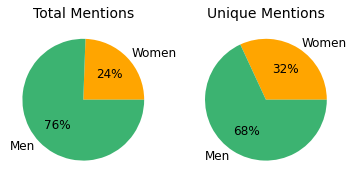

In [144]:
# Figure 2: percentage of men and women as experts

fig, ax = plt.subplots(1,2)
fig.patch.set_facecolor('white')

# total mentions
total = whole_qse['female_t'].sum() + whole_qse['male_t'].sum()
toplot = [whole_qse['female_t'].sum()/total, whole_qse['male_t'].sum()/total]
colors = ['orange','mediumseagreen']
sns.set_palette(sns.color_palette(colors))
ax[0].pie(toplot,labels=['Women','Men'],autopct='%.0f%%',textprops={'fontsize': 12})
ax[0].set_title('Total Mentions',fontsize=14)#,y=-.05)

# unique mentions
men = []
women = []
for i, x in whole_qse.iterrows():
    for person, gender in zip(ast.literal_eval(x.people),ast.literal_eval(x.gender_t)):
        if gender == 'male':
            men.append(person)
        elif gender == 'female':
            women.append(person)
men = list(set(men))
women = list(set(women))
total = len(men) + len(women)
toplot2 = [len(women)/total, len(men)/total]
ax[1].pie(toplot2,labels=['Women','Men'],autopct='%.0f%%', textprops={'fontsize': 12})
ax[1].set_title('Unique Mentions',fontsize=14) 
ax[1].title.set_position([0.5,-.8])

Difference in average sentence length
Average number of characters for sentences featuring men:  238.8378426984254
Average number of characters for sentences featuring women:  235.71453771289538
t-test:  Ttest_indResult(statistic=3.0461606415319764, pvalue=0.002319636323542075)
Presence of another expert
Percentage of sentences with expert women also featuring at least one expert man:  0.04641119221411192
Percentage of sentences with expert men also featuring at least on expert woman:  0.013288306290464392


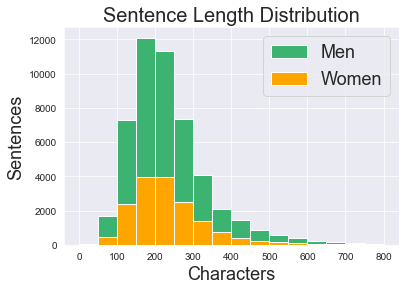

In [163]:
# Plotting the difference in sentence length

whole_qse["quote_length"] = whole_qse.quote.str.len()
any_men = whole_qse[whole_qse.male_t > 0]
any_women = whole_qse[whole_qse.female_t > 0]
more_men = whole_qse

plt.hist(any_men.quote_length.values,bins=[x for x in np.arange(0,850,50)],color="mediumseagreen",label="Men")
plt.hist(any_women.quote_length.values,bins=[x for x in np.arange(0,850,50)],color="orange",label="Women")
plt.title("Sentence Length Distribution",fontsize=20)
plt.xlabel("Characters",fontsize=18,)
plt.ylabel("Sentences",fontsize=18)
plt.legend(fontsize=18)

print("Difference in average sentence length")
print("Average number of characters for sentences featuring men: ",whole_qse[whole_qse.male_t > 0].quote.str.len().mean())
print("Average number of characters for sentences featuring women: ",whole_qse[whole_qse.female_t > 0].quote.str.len().mean())
print("t-test: ",scipy.stats.ttest_ind(a=any_men.quote_length, b=any_women.quote_length, equal_var = False))

print("Presence of another expert")
print("Percentage of sentences with expert women also featuring at least one expert man: ", whole_qse[whole_qse.female_t > 0].male_t.sum() / whole_qse[whole_qse.female_t > 0].shape[0])
print("Percentage of sentences with expert men also featuring at least on expert woman: ", whole_qse[whole_qse.male_t > 0].female_t.sum() / whole_qse[whole_qse.male_t > 0].shape[0])

In [ ]:
from random import sample, choices
import scipy

#
# BOOTSTRAPPING DATASET
#

n_resamples = 1000
whole_qse_bs = pd.DataFrame()
stat = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
for outlet in ['HUFF','CNN','NYT','FOX','NYP','BREIT']:
    print(outlet)
    idxs = whole_qse[whole_qse.outlet == outlet].index.values
    sample_size = len(idxs)
    # manual bootstrap computation
    tempdf_total = pd.DataFrame()
    for i in np.arange(n_resamples):
        tempdf = whole_qse.loc[choices(list(idxs),k=sample_size)] # samples with replacement
        tempdf_total = tempdf_total.append([tempdf])
        tempprop = tempdf.female_t.sum() / tempdf.male_t.sum()
        stat = stat.append([[tempprop, outlet]])
    whole_qse_bs = whole_qse_bs.append([tempdf_total])
stat.index = np.arange(stat.shape[0])
stat.columns = ['avg','outlet']

# Statistics for percentage of quotees that are men
stat_ratio = pd.DataFrame()
for label in ['HUFF','CNN','NYT','FOX','NYP','BREIT']:
    stat_ratio = stat_ratio.append([[stat[stat.outlet == label].mean(axis=0).values[0], np.std(stat[stat.outlet == label].avg,axis=0), label]])
stat_ratio.index = np.arange(stat_ratio.shape[0])
stat_ratio.columns = ['mean','stddev','outlet']

In [167]:
whole_qse_bs = pd.read_csv("data/whole_qse_bs.csv")
stat_ratio = pd.read_csv("data/stat_ratio.csv")

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [168]:
## bootstrapping for organization type
n_resamples = 1000
sample_size = 1000
qse_bs = pd.DataFrame()

whole_qse_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_qse.shape[0]
for i in np.arange(n_resamples):
    tempdf = whole_qse.loc[choices(list(whole_qse.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['whole', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

whole_educ_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_educ.shape[0]
for i in np.arange(n_resamples):
    #tempdf = whole_educ.loc[sample(list(whole_educ.index.values),sample_size)]
    tempdf = whole_educ.loc[choices(list(whole_educ.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['educ', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

whole_gov_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_gov.shape[0]
for i in np.arange(n_resamples):
    #tempdf = whole_gov.loc[sample(list(whole_gov.index.values),sample_size)]
    tempdf = whole_gov.loc[choices(list(whole_gov.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['gov', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

whole_thinkt_bs = pd.DataFrame()
stat_m = pd.DataFrame()
stat_w = pd.DataFrame()
stat_au = pd.DataFrame()
sample_size = whole_thinkt.shape[0]
for i in np.arange(n_resamples):
    #tempdf = whole_thinkt.loc[sample(list(whole_thinkt.index.values),sample_size)]
    tempdf = whole_thinkt.loc[choices(list(whole_thinkt.index.values),k=sample_size)]
    stat_m = stat_m.append([tempdf.male_t.sum()])
    stat_w = stat_w.append([tempdf.female_t.sum()])
    stat_au = stat_au.append([tempdf.andy_t.sum() + tempdf.unknown_t.sum()])
qse_bs = qse_bs.append([['thinkt', (stat_m/sample_size).mean().values[0], np.std(stat_m / sample_size).values[0],(stat_w/sample_size).mean().values[0], np.std(stat_w / sample_size).values[0],(stat_au/sample_size).mean().values[0], np.std(stat_au / sample_size).values[0]]])

qse_bs.index = np.arange(4)
qse_bs.columns = ['type','mu_m','std_m','mu_w','std_w','mu_au','std_au']
qse_bs

,type,mu_m,std_m,mu_w,std_w,mu_au,std_au
0,whole,0.575650,0.001806,0.186128,0.001333,0.284451,0.001549
1,educ,0.585593,0.007144,0.246872,0.005844,0.207220,0.005533
2,gov,0.654966,0.004093,0.171459,0.003136,0.221527,0.003404
3,thinkt,0.527086,0.008226,0.208381,0.006328,0.303195,0.007399


Text(0.5, 1.0, 'Gender Composition by Organization Type')

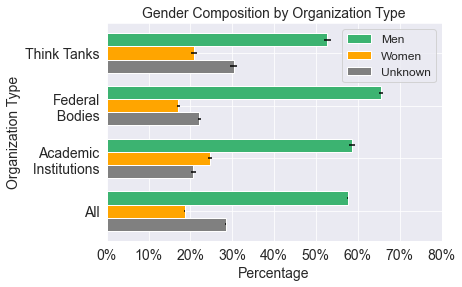

In [169]:
# Figure 3: Gender composition for each type of organization

sns.set_style('darkgrid')
plt.barh(np.arange(4) + .25, qse_bs.mu_m,.25,label='Men',xerr = qse_bs.std_m, color = 'mediumseagreen')
plt.barh(np.arange(4), qse_bs.mu_w,.25,label='Women',xerr = qse_bs.std_w, color='orange')
plt.barh(np.arange(4) - .25, qse_bs.mu_au,.25,label='Unknown',xerr = qse_bs.std_au, color='gray')
plt.yticks(np.arange(4),['All','Academic\n Institutions','Federal\n Bodies','Think Tanks'],fontsize=14)
plt.xticks(np.arange(0,.9,.1),[str(i)+"%" for i in np.arange(0,90,10)],fontsize=14)
plt.ylabel("Organization Type",fontsize=14)
plt.xlabel("Percentage",fontsize=14)
plt.legend(fontsize=12)
plt.title("Gender Composition by Organization Type",fontsize=14)

Text(0.5, 1.0, 'Organization Affiliation by News Outlet')

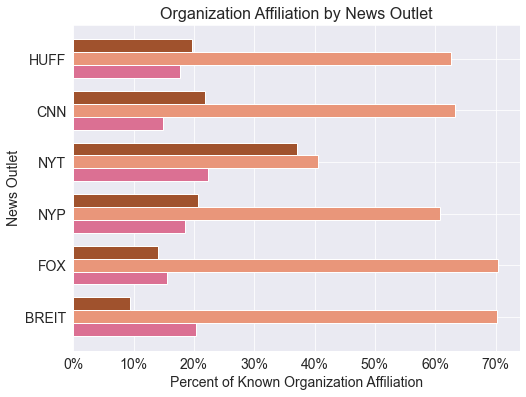

In [170]:
# Figure 4: Each news outlet's composition of organization type 
# out of those quotes matching to academic, federal and think tank org types

x = ["BREIT","FOX","NYP","NYT","CNN","HUFF"]
toplot = pd.DataFrame()
for l in x:
    educ_slice = whole_educ[whole_educ.outlet == l]
    gov_slice = whole_gov[whole_gov.outlet == l]
    thinkt_slice = whole_thinkt[whole_thinkt.outlet == l]
    total = educ_slice.shape[0] + gov_slice.shape[0] + thinkt_slice.shape[0]
    toplot = toplot.append(pd.DataFrame([[l,educ_slice.shape[0]/total,gov_slice.shape[0]/total,thinkt_slice.shape[0]/total]]))
toplot.columns = ['outlet','educ','gov','thinkt']
plt.figure(figsize=(8,6))
plt.barh(np.arange(6) - .25, toplot.thinkt,.25,label='Think \nTanks',color='palevioletred')
plt.barh(np.arange(6),toplot.gov,.25,label='Federal',color='darksalmon')
plt.barh(np.arange(6) + .25,toplot.educ,.25,label='Academic',color='sienna')
plt.yticks(np.arange(6),x,fontsize=14)
plt.xticks(np.arange(0,0.71,0.1),[str(i)+"%" for i in np.arange(0,80,10)],fontsize=14)
#plt.legend(fontsize=18,facecolor='white',framealpha=1)
plt.xlabel("Percent of Known Organization Affiliation",fontsize=14)
plt.ylabel("News Outlet",fontsize=14)
plt.title("Organization Affiliation by News Outlet",fontsize=16)

## IDEOLOGICAL BIAS

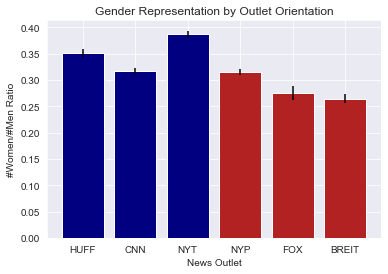

In [173]:
# Figure 5: Ratio of gender representation by news outlet, ordered by political leaning

def bar_plot(df, label = "Gender"):
    x = ["HUFF", "CNN", "NYT", "NYP", "FOX", "BREIT"]
    toplot = pd.DataFrame()
    toplot2 = pd.DataFrame()
    for l in x:
        df_slice = df[df.outlet == l]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = toplot.append(pd.DataFrame([[df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]],columns=["M","W","A"],index=[l]))
        toplot2 = toplot2.append(pd.DataFrame([[df_slice["female_t"].sum()/df_slice["male_t"].sum()]],index = [l],columns=['ratio']))
    plt.bar(x,toplot2.ratio,color=['navy','navy','navy','firebrick','firebrick','firebrick'],yerr=stat_ratio.stddev)
    #plt.legend()
    plt.xlabel("News Outlet")
    plt.ylabel("#Women/#Men Ratio")
    plt.title("Gender Representation by Outlet Orientation")
    return toplot2

outlet_ratios = bar_plot(whole_qse)

#print("Kruska-Wallis Test:")
#scipy.stats.kruskal(outlet_ratios.ratio.values,outlet_ratios.lean.values) 

## PRESTIGE BIAS

In [174]:
# Define gini coefficient
# https://www.statology.org/gini-coefficient-python/
# works on list of ranking 
import itertools

def gini(x):
    total = 0
    for i, xi in enumerate(x):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

# gini coefficient from list of rankings
# i.e. if rank 1 has 2 citations and rank 2 has 3 citations,
# we take gini coeffieent of the list [1, 1, 2, 2, 2]
gini(np.array(list(itertools.chain.from_iterable([[i]*x.c_total for i, x in times15.iterrows()]))))

0.572648324077025

WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.33783331020120494, pvalue=3.669658748258977e-12)
Gini:  0.5683412384257613
Pearson corr:  (-0.33340025731434475, 7.255545535972892e-12)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3785622753485839, pvalue=1.885405592101747e-07)
Gini:  0.5683412384257613
Pearson corr: (-0.34190808347937807, 2.996866560557945e-06)


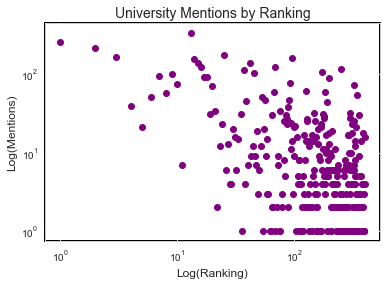

In [175]:
# Figure 6: Number of mentions of an academic institution as a function of its ranking

from scipy.stats import pearsonr

N = 401
fig, ax = plt.subplots()
nozeroes = times15.loc[times15.c_total > 0]
ax.scatter(nozeroes.index,nozeroes.c_total,color='purple')
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')  

plt.xlabel("Log(Ranking)",fontsize=12)
plt.ylabel("Log(Mentions)",fontsize=12)
plt.title("University Mentions by Ranking",fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')

print("WITH ZERO COUNTS")
rank_cit = pd.DataFrame([times15.index.values,times15.c_huff.values]).T
rank_cit.columns = ['rank_', 'citations']
print("Spearman corr: ",scipy.stats.spearmanr(rank_cit.rank_.values,rank_cit.citations.values))
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*x.citations for i, x in rank_cit.iterrows()])))))
print("Pearson corr: ",scipy.stats.pearsonr(rank_cit.rank_.values,rank_cit.citations.values))

rank_cit = rank_cit[rank_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(rank_cit.rank_.values,rank_cit.citations.values))
rank_cit
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*x.citations for i, x in rank_cit.iterrows()])))))
print("Pearson corr:",pearsonr(rank_cit.rank_.values,rank_cit.citations))

LEFT-LEANING
Gini:  0.5733573852149372
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.43867058465249653, pvalue=2.7343489110422166e-20)
Pearson corr:  (-0.3768467431848862, 5.598299175763653e-15)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.43867058465249653, pvalue=2.7343489110422166e-20)
Pearson corr: (-0.3768467431848862, 5.598299175763653e-15)

RIGHT-LEANING
Gini:  0.5616452371823026
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3168174925608485, pvalue=8.444760134134967e-11)
Pearson corr:  (-0.3228167147568172, 3.535446830337589e-11)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3168174925608485, pvalue=8.444760134134967e-11)
Pearson corr: (-0.3228167147568172, 3.535446830337589e-11)


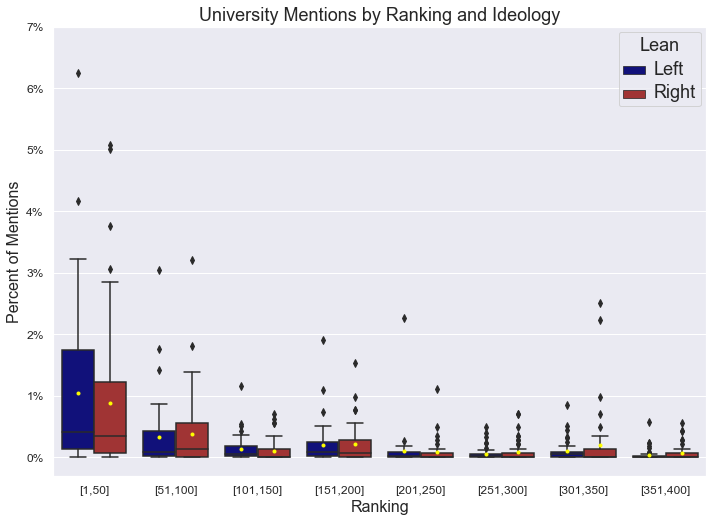

In [176]:
# Figure 8: Academic instituion mentions by ranking, by political leaning of news outlet
# Gini, spearman and pearson reported by political affiliation

print("LEFT-LEANING")
left_cit = pd.DataFrame([times15.index.values,times15.c_huff.values + times15.c_cnn.values + times15.c_nyt.values]).T
left_cit.columns = ['rank_', 'citations']
left_cit['citations_norm'] = left_cit.citations / left_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[i]*int(x.citations) for i, x in left_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(left_cit.rank_.values,left_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(left_cit.rank_.values,left_cit.citations.values))
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(left_cit.rank_.values,left_cit.citations.values))
print("Pearson corr:",pearsonr(left_cit.rank_.values,left_cit.citations))

print("\nRIGHT-LEANING")
right_cit = pd.DataFrame([times15.index.values,times15.c_breit.values + times15.c_fox.values + times15.c_nyp.values]).T
right_cit.columns = ['rank_', 'citations']
right_cit['citations_norm'] = right_cit.citations / right_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in right_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(right_cit.rank_.values,right_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(right_cit.rank_.values,right_cit.citations.values))
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(right_cit.rank_.values,right_cit.citations.values))
print("Pearson corr:",pearsonr(right_cit.rank_.values,right_cit.citations))

left_cit2 = left_cit.copy()
left_cit2.columns = ['rank_', 'citations', 'norm']
left_cit2["Lean"] = "Left"
right_cit2 = right_cit.copy()
right_cit2.columns = ['rank_', 'citations', 'norm']
right_cit2["Lean"] = "Right"
lean_cit2 = pd.concat([left_cit2,right_cit2])
colors = ['darkblue','firebrick']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette(colors))

left_cit2["bin"] = 0
right_cit2["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        lean_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
        left_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
        right_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        lean_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i
        left_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i
        right_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i


bins_names = ["[1,50]","[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,400]"]
p = sns.boxplot(y='norm',x='bin',data=lean_cit2,hue='Lean',showmeans=True,meanprops={"marker":".","markerfacecolor":"yellow", "markeredgecolor":"yellow"})#,split=False)
p.set_xlabel("Ranking",fontsize=16)
p.set_ylabel("Percent of Mentions",fontsize=16)
plt.xticks(np.arange(8),bins_names,fontsize=12)
#plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)
plt.title("University Mentions by Ranking and Ideology", fontsize=18)
plt.setp(p.get_legend().get_title(), fontsize=18)
plt.setp(p.get_legend().get_texts(), fontsize=18)
plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)

means_left = left_cit2.groupby(['bin']).mean().norm
means_right = right_cit2.groupby(['bin']).mean().norm


In [177]:
# Ranking of mentions of women, re-calculated according to gender
# Gini, Spearman and Pearson reported for experts of men/women gender category and prestige 

times15["c_total_f"] = 0; times15["c_breit_f"] = 0; times15["c_nyp_f"] = 0; times15["c_fox_f"] = 0;
times15["c_cnn_f"] = 0; times15["c_nyt_f"] = 0; times15["c_huff_f"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["female_t"] > 0]
        times15.loc[i,"c_"+l.lower()+"_f"] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total_f"] = total
times15["c_total_m"] = 0; times15["c_breit_m"] = 0; times15["c_nyp_m"] = 0; times15["c_fox_m"] = 0;
times15["c_cnn_m"] = 0; times15["c_nyt_m"] = 0; times15["c_huff_m"] = 0# introduce column to count university mentions
for i, x in times15.iterrows():
    univ = x.university_name
    total = 0
    for l in ["BREIT","NYP","FOX","CNN","NYT","HUFF"]:
        df_slice = whole_educ_clean[whole_educ_clean.outlet == l]
        df_slice = df_slice[df_slice.educ_inst.str.contains(univ)]
        df_slice = df_slice[df_slice["male_t"] > 0]
        times15.loc[i,"c_"+l.lower()+"_m"] = df_slice.shape[0]
        total += df_slice.shape[0]
    times15.loc[i,"c_total_m"] = total

print("WOMEN")
women_cit = pd.DataFrame([times15.index.values,times15.c_total_f.values]).T
women_cit.columns = ['rank_', 'citations']
women_cit["citations_norm"] = women_cit.citations / women_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in women_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(women_cit.rank_.values,women_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(women_cit.rank_.values,women_cit.citations.values))
#women_cit = women_cit[women_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(women_cit.rank_.values,women_cit.citations.values))
print("Pearson corr:",pearsonr(women_cit.rank_.values,women_cit.citations))

print("\nMEN")
men_cit = pd.DataFrame([times15.index.values,times15.c_total_m.values]).T
men_cit.columns = ['rank_', 'citations']
men_cit["citations_norm"] = men_cit.citations / men_cit.citations.sum()
print("Gini: ",gini(np.array(list(itertools.chain.from_iterable([[int(i)]*int(x.citations) for i, x in men_cit.iterrows()])))))
print("WITH ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(men_cit.rank_.values,men_cit.citations.values))
print("Pearson corr: ",scipy.stats.pearsonr(men_cit.rank_.values,men_cit.citations.values))
#men_cit = men_cit[men_cit.citations > 0]
print("WITHOUT ZERO COUNTS")
print("Spearman corr: ",scipy.stats.spearmanr(men_cit.rank_.values,men_cit.citations.values))
print("Pearson corr:",pearsonr(men_cit.rank_.values,men_cit.citations))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


WOMEN
Gini:  0.559512867961588
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.40904374687477585, pvalue=1.3179556044131033e-17)
Pearson corr:  (-0.35306501485517633, 3.2418895452492115e-13)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.40904374687477585, pvalue=1.3179556044131033e-17)
Pearson corr: (-0.35306501485517633, 3.2418895452492115e-13)

MEN
Gini:  0.5718515078519029
WITH ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3972353880389898, pvalue=1.3100534823701557e-16)
Pearson corr:  (-0.364123142767776, 5.120593947515351e-14)
WITHOUT ZERO COUNTS
Spearman corr:  SpearmanrResult(correlation=-0.3972353880389898, pvalue=1.3100534823701557e-16)
Pearson corr: (-0.364123142767776, 5.120593947515351e-14)


Text(0.5, 1.0, '100 Highest Ranked Universities as Percent of Total Mentions')

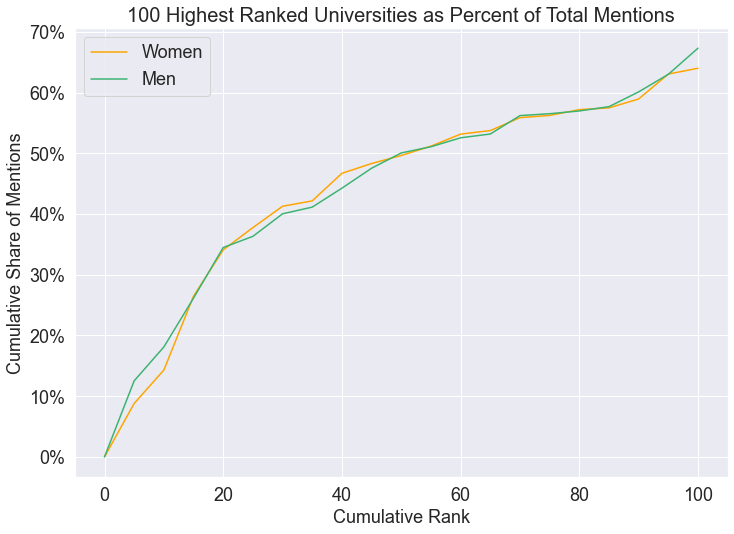

In [178]:
# Figure 9: Cumulative distribution of mentions for top 100 institutions broken by gender

cumulative_pct = pd.DataFrame()
for n in np.arange(0,105,5):
    cumulative_pct = cumulative_pct.append([[n,women_cit[:n].citations_norm.sum(),men_cit[:n].citations_norm.sum(),women_cit[:n].citations.sum(), men_cit[:n].citations.sum()]])
cumulative_pct.index = np.arange(cumulative_pct.shape[0])
cumulative_pct.columns = ['n','pct_w','pct_m','sum_w','sum_m']

plt.plot(cumulative_pct.n,cumulative_pct.pct_w, color='orange', label = 'Women')
plt.plot(cumulative_pct.n,cumulative_pct.pct_m, color='mediumseagreen', label = 'Men')
plt.legend(fontsize=18)
plt.xlabel("Cumulative Rank",fontsize=18)
plt.ylabel("Cumulative Share of Mentions",fontsize=18)
plt.yticks(np.arange(0.0,.75,0.1),[str(k)+"%" for k in np.arange(0,75,10)],fontsize=18)
plt.xticks(fontsize=18)
plt.title("100 Highest Ranked Universities as Percent of Total Mentions",fontsize=20)

[None, None, None, None]

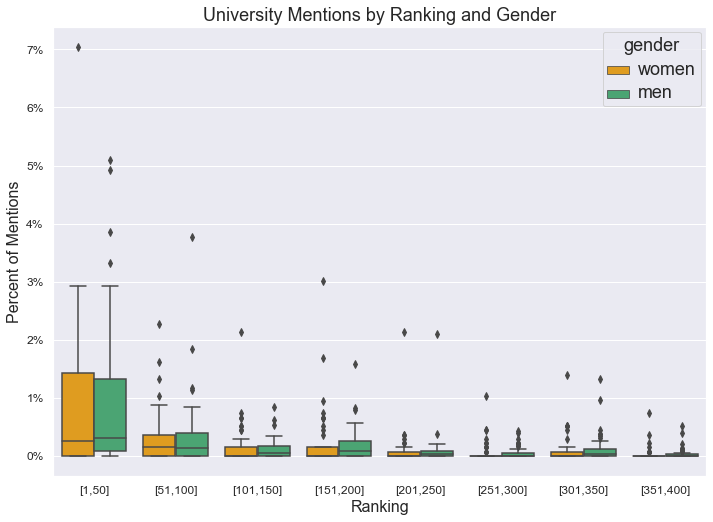

In [179]:
# Boxplot of women and men expert mentions broken down by university prestige level

women_cit2 = women_cit.copy()
women_cit2.columns = ['rank_', 'citations', 'norm']
women_cit2["gender"] = 'women'
men_cit2 = men_cit.copy()
men_cit2.columns = ['rank_', 'citations', 'norm']
men_cit2["gender"] = 'men'
gender_cit2 = pd.concat([women_cit2,men_cit2])
colors = ['orange','mediumseagreen','violet']
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette(colors))

gender_cit2["bin"] = 0
for i in np.arange(0,8):
    if i == 0:
        gender_cit2.loc[np.arange(i*50,50+i*50),"bin"] = i
    else:
        gender_cit2.loc[np.arange(1+i*50,50+i*50),"bin"] = i


bins_names = ["[1,50]","[51,100]","[101,150]","[151,200]","[201,250]","[251,300]","[301,350]","[351,400]"]
p = sns.boxplot(y='norm',x='bin',data=gender_cit2,hue='gender')
p.set_xlabel("Ranking",fontsize=16)
p.set_ylabel("Percent of Mentions",fontsize=16)
plt.xticks(np.arange(8),bins_names,fontsize=12)
plt.yticks(np.arange(0,0.07,0.01),["0%","1%","2%","3%","4%","5%","6%","7%"],fontsize=12)
plt.title("University Mentions by Ranking and Gender", fontsize=18)
plt.setp(p.get_legend().get_title(), fontsize=18)
plt.setp(p.get_legend().get_texts(), fontsize=18)


# OTHER ANALYSIS
Excerpt of experiments not included in the official report

Text(0.5, 1.0, 'Top Reporting Verbs for Women')

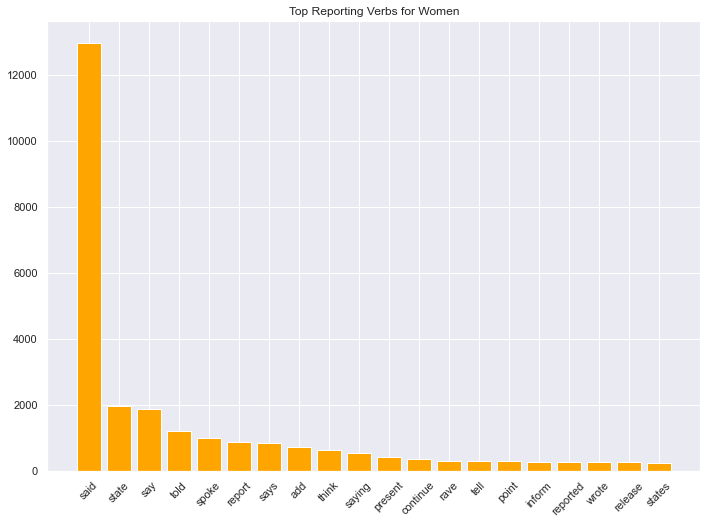

In [191]:
verb_count_m = pd.DataFrame([reporting_verbs, [0] * len(reporting_verbs)]).T
verb_count_m.columns = ['verb','counts']
verb_count_f = pd.DataFrame([reporting_verbs, [0] * len(reporting_verbs)]).T
verb_count_f.columns = ['verb','counts']

for i, x in verb_count_m.iterrows():
    verb_count_f.loc[i,'counts'] += whole_qse.loc[whole_qse.quote.str.contains(x.verb)].female_t.sum()
    verb_count_m.loc[i,'counts'] += whole_qse.loc[whole_qse.quote.str.contains(x.verb)].male_t.sum()

n = 20
sort_counts = verb_count_f.sort_values(by='counts', ascending=False)[:n]
plt.bar(sort_counts.verb, sort_counts.counts)
plt.xticks(rotation=45)
plt.title("Top Reporting Verbs for Women")


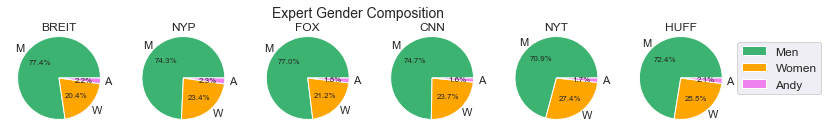

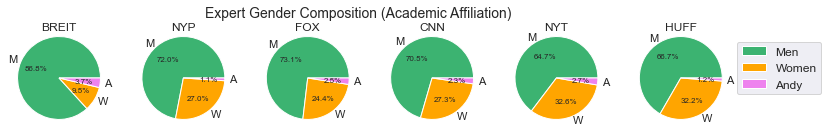

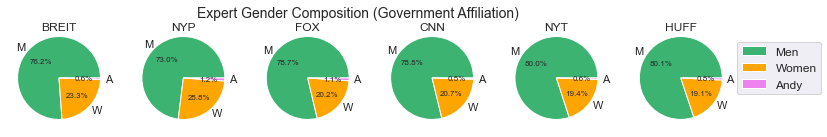

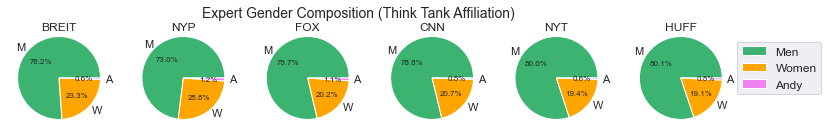

In [197]:
# Pie charts showing expert composition for each organization type

# Functions for plotting by gender
# inludes unknown category, and each dataframe yields a single plot

def plot_multi_bygender_h(df,label = 'Total by Gender'):
    def plot_outlet(label, axis1, labels = ["Men", "Women", "Androgynous"]):
        df_slice = df[df.outlet == label]
        total = df_slice["male_t"].sum() + df_slice["female_t"].sum() + df_slice["andy_t"].sum()
        toplot = [df_slice["male_t"].sum()/total, df_slice["female_t"].sum()/total, df_slice["andy_t"].sum()/total]
        pd.DataFrame(toplot).plot(kind='pie', figsize=(5,5),labels=["M","W","A"],autopct='%1.1f%%',subplots=True,ax = axes[axis1],colors=['mediumseagreen','orange','violet'])
        axes[axis1].get_legend().remove()
        axes[axis1].set(ylabel='')#,aspect='equal')
        axes[axis1].set_title(label,y=.9)
    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(1,6,figsize=(13,2))
    plot_outlet('BREIT',0)
    plot_outlet('NYP',1)
    plot_outlet('FOX',2)
    plot_outlet('HUFF',5)
    plot_outlet('CNN',3)
    plot_outlet('NYT',4)
    fig.legend(["Men", "Women", "Andy"],loc = 7, fontsize = 12)
    fig.suptitle(label, y = 1, fontsize=14)
    plt.show()

def plot_unique_bygender(df,label = 'Unique by Gender',path = 'default'):
    df2, past = get_genders_unique(df)
    total = df["male_u"].sum() + df["female_u"].sum() + df["andy_u"].sum() + df["unknown_u"].sum()
    labels = ["Male","Female","Androgenous","Unknown"]
    sizes = [df["male_u"].sum()/total, df["female_u"].sum()/total, df["andy_u"].sum()/total, df["unknown_u"].sum()/total]
    fig, ax = plt.subplots()
    ax.pie(sizes,labels=labels,autopct='%1.1f%%')
    ax.axis('equal')
    ax.set_title(label)
    if path != 'default':
        plt.savefig(path)
    plt.show()
    return (df2, past)

plot_multi_bygender_h(whole_qse,label="Expert Gender Composition")
plot_multi_bygender_h(whole_educ,label="Expert Gender Composition (Academic Affiliation)")
plot_multi_bygender_h(whole_gov,label="Expert Gender Composition (Government Affiliation)")
plot_multi_bygender_h(whole_gov,label="Expert Gender Composition (Think Tank Affiliation)")

Text(0.5, 1.0, 'Overall Gender Composition')

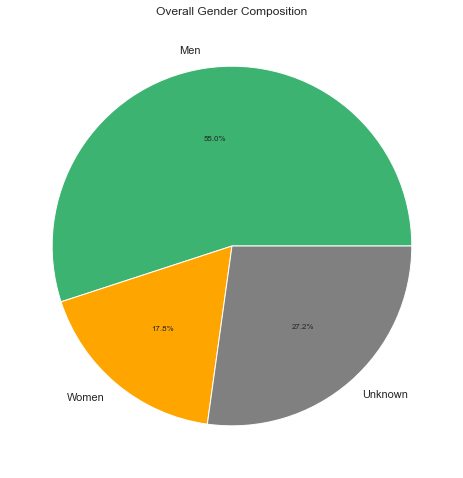

In [194]:
# Gender Composition pie chart where andy and unknown are a single combined category

total = whole_qse['female_t'].sum() + whole_qse['male_t'].sum() + whole_qse['andy_t'].sum() #+ whole_qse['unknown_t'].sum()
toplot = [whole_qse['male_t'].sum()/total, whole_qse['female_t'].sum()/total, (whole_qse['andy_t'].sum() + whole_qse['unknown_t'].sum())/total]
plt.pie(toplot, colors=['mediumseagreen','orange','gray'],labels=['Men','Women','Unknown'],autopct='%1.1f%%')
plt.title('Overall Gender Composition')

In [196]:
# Get full quotes from partial extractions
def full_from_partial(og_df,df):
    for i, row in df.iterrows():
        og_loc = og_df.loc[row["idx"]]
        sentences = [sent.text for sent in nlp(og_loc["text"]).sents]
        df.loc[i,'quote'] = str([x for x in sentences if row["quote"][1:-1] in x])[1:-1]